### Different imports

In [1]:
import numpy as np
import geopandas
import pandas
import shapely.geometry, shapely.wkt
import matplotlib.pyplot as plt
from osgeo import osr, ogr
import time
import pyproj
from datetime import datetime

### Define a function to draw the different graphics below

In [2]:
def graphics(dataList, colorsList, title):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    for i in range (len(dataList)):
        try:
            dataList[i].plot(ax=ax, color=colorsList[i])
        except AttributeError:
            plt.plot(dataList[i][0], dataList[i][1], color=colorsList[i])
    
    plt.suptitle(title, size='xx-large', weight='bold', y=0.95)
    
    if max(dataList[0].geometry.bounds.maxx) > 800000:
        ax.set_xlim(-100000, 1500000)
        ax.xaxis.set_ticks(np.arange(-200000, 1500001, 200000))
        
        ax.set_ylim(0, 1500000)
        ax.yaxis.set_ticks(np.arange(0, 1500001, 200000))
        
    else:
        ax.set_xlim(400000, 800000)
        ax.xaxis.set_ticks(np.arange(400000, 800001, 100000))
        
        ax.set_ylim(500000, 1000000)
        ax.yaxis.set_ticks(np.arange(500000, 1000001, 100000))
    
    ax.set_xlabel('Longitude', size='large', weight='bold')
    ax.set_ylabel('Latitude', size='large', weight='bold')

    ax.grid(True)
    
    plt.show()

### Ireland map with GADM data

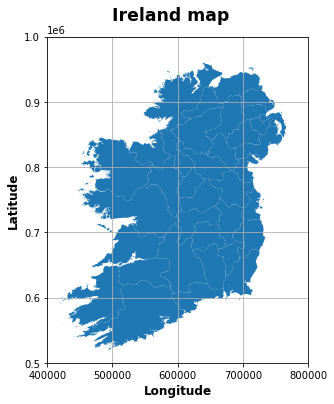

In [3]:
pandasSouth = geopandas.read_file('gadm36_IRL_1.shp')
pandasNorth = geopandas.read_file('gadm36_GBR_2.shp')

pandasSouth = geopandas.GeoDataFrame(pandasSouth, crs='epsg:4326', geometry='geometry')
pandasSouth = pandasSouth.to_crs('epsg:2157')

pandasNorth = geopandas.GeoDataFrame(pandasNorth, crs='epsg:4326', geometry='geometry')
pandasNorth = pandasNorth.to_crs('epsg:2157')

pandasNorth = pandasNorth.query("NAME_1 == 'Northern Ireland'")

pandasIreland = pandas.concat([pandasSouth, pandasNorth], join='inner')

graphics([pandasIreland], ['C0'], 'Ireland map')

### Read quadrats data from shapefile

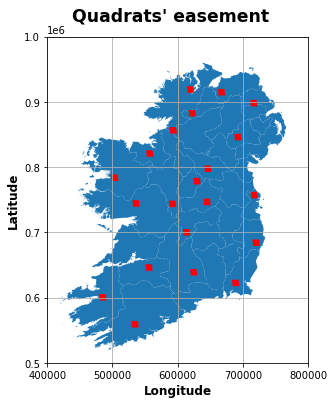

In [4]:
pandasQuadrats = geopandas.read_file('agriclimate_quadrats_Ireland.shp')

prj_file = open('agriclimate_quadrats_Ireland.prj', 'r')
prj_txt = prj_file.read()

srs = osr.SpatialReference()
srs.ImportFromESRI([prj_txt])

proj4Quadrats = srs.ExportToProj4()

# IRENET95 / Irish Transverse Mercator, epsg:2157
pandasQuadrats = geopandas.GeoDataFrame(pandasQuadrats, crs=proj4Quadrats, geometry='geometry')
pandasQuadrats = pandasQuadrats.to_crs('epsg:2157')

graphics([pandasIreland, pandasQuadrats], ['C0', 'r'], "Quadrats' easement")

### Read filtered Agristats data

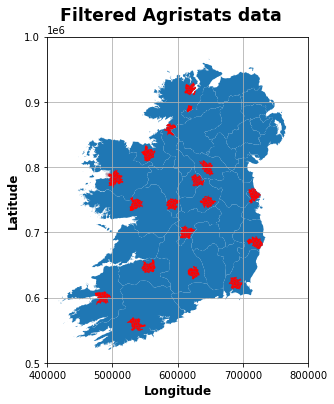

In [5]:
pandasFilteredAgristats = pandas.read_csv('AgristatsSimplified.txt', sep=';')
pandasFilteredAgristats['geometry'] = pandasFilteredAgristats['geometry'].apply(shapely.wkt.loads)
pandasFilteredAgristats = geopandas.GeoDataFrame(pandasFilteredAgristats, crs='epsg:2157', geometry='geometry')

graphics([pandasIreland, pandasFilteredAgristats], ['C0', 'r'], 'Filtered Agristats data')

### Read MÉRA data from .txt file

In [6]:
tic = time.time()

columnsName = ['Latitude', 'Longitude', 'Value', 'dataDate', 'dataTime', 'validityDate', 'validityTime']
columnsType = {'Latitude': float, 'Longitude': float, 'Value': float, 'dataDate': int, 'dataTime': int,
               'validityDate': int, 'validityTime': int}

fileName = 'TotalPrecip_2017_01.txt'

pandasClimate = pandas.read_csv(fileName, delim_whitespace=True, names=columnsName,
                               na_values=['Latitude,', 'Longitude,', 'Value,', 'dataDate,', 'dataTime,', 'validityDate,', 'validityTime'])
pandasClimate = pandasClimate.dropna()
pandasClimate = pandasClimate.astype(columnsType)

tac = time.time()

print ('Reading time: {} seconds\n'.format(round(tac-tic,3)))
print (pandasClimate)

Reading time: 23.527 seconds

         Latitude  Longitude     Value  dataDate  dataTime  validityDate  \
1          46.834    345.391  0.000000  20170101         0      20170102   
2          46.840    345.422  0.000000  20170101         0      20170102   
3          46.846    345.454  0.000000  20170101         0      20170102   
4          46.852    345.485  0.000000  20170101         0      20170102   
5          46.858    345.517  0.000000  20170101         0      20170102   
...           ...        ...       ...       ...       ...           ...   
8019137    59.598      1.965  0.054298  20170131         0      20170201   
8019138    59.599      2.010  0.056274  20170131         0      20170201   
8019139    59.600      2.054  0.057266  20170131         0      20170201   
8019140    59.601      2.098  0.058250  20170131         0      20170201   
8019141    59.602      2.142  0.058250  20170131         0      20170201   

         validityTime  
1                 900  
2        

### That's not usefull to work on the whole dataset

In [7]:
pandasClimate = pandasClimate.reset_index(drop=True)

nbDays = len(set(pandasClimate.validityDate))
print ('The numbers of measured days: {}'.format(nbDays))

stepDays = len(pandasClimate[pandasClimate.validityDate == pandasClimate.validityDate[1]])
print ('The number of measurements on each day: {}\n'.format(stepDays))

print ('           day i:', pandasClimate.loc[[5]].Latitude.values, pandasClimate.loc[[5]].Longitude.values)
print ('day i + stepDays:', pandasClimate.loc[[stepDays+5]].Latitude.values, pandasClimate.loc[[stepDays+5]].Longitude.values, '\n')

pandasClimateOne = pandasClimate[pandasClimate.validityDate == pandasClimate.validityDate[1]]

print (pandasClimateOne)

The numbers of measured days: 31
The number of measurements on each day: 258681

           day i: [46.864] [345.548]
day i + stepDays: [46.864] [345.548] 

        Latitude  Longitude  Value  dataDate  dataTime  validityDate  \
0         46.834    345.391    0.0  20170101         0      20170102   
1         46.840    345.422    0.0  20170101         0      20170102   
2         46.846    345.454    0.0  20170101         0      20170102   
3         46.852    345.485    0.0  20170101         0      20170102   
4         46.858    345.517    0.0  20170101         0      20170102   
...          ...        ...    ...       ...       ...           ...   
258676    59.598      1.965    0.0  20170101         0      20170102   
258677    59.599      2.010    0.0  20170101         0      20170102   
258678    59.600      2.054    0.0  20170101         0      20170102   
258679    59.601      2.098    0.0  20170101         0      20170102   
258680    59.602      2.142    0.0  20170101       

### Recuperate proj4 string for MÉRA data

In [8]:
prj_txt = """GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]"""

srs = osr.SpatialReference()
srs.ImportFromESRI([prj_txt])

proj4Mera = srs.ExportToProj4()

### Recuperate areas of interest

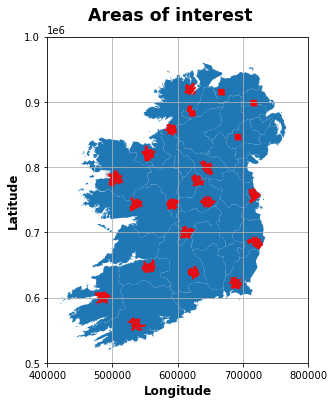

In [9]:
interestPoly = list(pandasFilteredAgristats.geometry.values)

for polyQ in pandasQuadrats.geometry:
    
    intersect = []
    
    for polyA in pandasFilteredAgristats.geometry:
        if polyA.intersects(polyQ):
            intersect.append(polyA)
    
    diff = polyQ
    for polyI in intersect:
        diff = diff.difference(polyI)
        
    interestPoly.append(diff)
    
pandasInterest = geopandas.GeoDataFrame(crs='epsg:2157', geometry=interestPoly)

graphics([pandasIreland, pandasInterest], ['C0', 'r'], 'Areas of interest')

### Recuperate boundaries from areas of interest to have a first coarse filtering

Length before filtering: 258681
              and after: 18118

Filtering time: 0.082 seconds


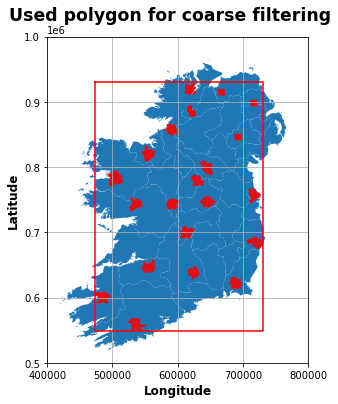

In [10]:
tic = time.time()

print ('Length before filtering: {}'.format(len(pandasClimateOne)))

minx = min(pandasInterest.geometry.bounds.minx)
miny = min(pandasInterest.geometry.bounds.miny)
maxx = max(pandasInterest.geometry.bounds.maxx)
maxy = max(pandasInterest.geometry.bounds.maxy)

polyInterest = shapely.geometry.Polygon([[minx,maxy], [maxx,maxy], [maxx,miny], [minx,miny]])

transformer = pyproj.Transformer.from_proj(pyproj.Proj('epsg:2157'), pyproj.Proj(proj4Mera))
polyProjected = shapely.ops.transform(transformer.transform, polyInterest)

boundaries = list(polyProjected.bounds)

# MÉRA just uses positive longitudes
if boundaries[0] < 0:
    boundaries[0] += 360

if boundaries[2] < 0:
    boundaries[2] += 360

# Take values a little bigger
pandasClimateOne = pandasClimateOne[(pandasClimateOne.Longitude > boundaries[0] - 0.1) & (pandasClimateOne.Longitude < boundaries[2] + 0.1)
                                   & (pandasClimateOne.Latitude > boundaries[1] - 0.1) & (pandasClimateOne.Latitude < boundaries[3] + 0.1)]

tac = time.time()
print ('              and after: {}\n'.format(len(pandasClimateOne)))
print ('Filtering time: {} seconds'.format(round(tac-tic, 3)))

graphics([pandasIreland, pandasInterest, polyInterest.exterior.xy], ['C0', 'r', 'r'], 'Used polygon for coarse filtering')

### Projects MÉRA data from WGS84 to IRENET95 and look at the coarse filtering

Projection time: 0.814 seconds


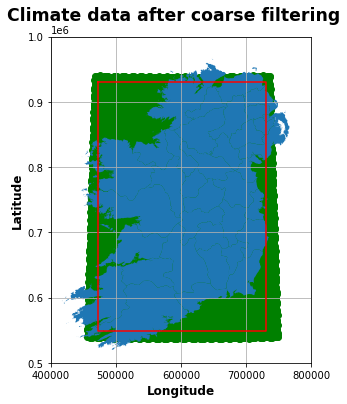

In [11]:
tic = time.time()

# The creation of the list geometry has to be improve if possible
geometry = [shapely.geometry.Point(lonlat) for lonlat in zip(pandasClimateOne.Longitude, pandasClimateOne.Latitude)]
geoClimateOne = geopandas.GeoDataFrame(pandasClimateOne, crs=proj4Mera, geometry=geometry)

geoClimateOne = geoClimateOne.to_crs('epsg:2157')

tac = time.time()
print ('Projection time: {} seconds'.format(round(tac-tic, 3)))

graphics([geoClimateOne, pandasIreland, polyInterest.exterior.xy], ['g', 'C0', 'r'], 'Climate data after coarse filtering')

### Second filtering with Agristats regions

Length before filtering: 18118
              and after: 780

Filtering time: 0.862 seconds


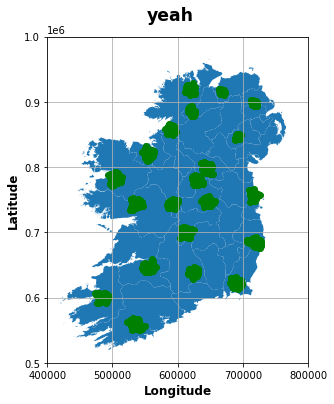

In [12]:
tic = time.time()

print ('Length before filtering: {}'.format(len(geoClimateOne)))

geoClimateOne = geopandas.sjoin(geoClimateOne, pandasInterest, op='within') 
geoClimateOne = geoClimateOne[geoClimateOne.index_right != 0]
geoClimateOne = geoClimateOne.drop(columns=['index_right'])

print ('              and after: {}\n'.format(len(geoClimateOne)))

tac = time.time()
print ('Filtering time: {} seconds'.format(round(tac-tic, 3)))

graphics([pandasIreland, geoClimateOne], ['C0', 'g'], 'yeah')

### Recuperate values for all days and perform treatment again

Number of values in a month after filtering: 24180

Processing time: 2.397 seconds


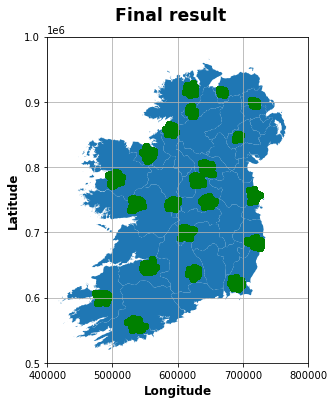

In [13]:
tic = time.time()

indexes = np.array(geoClimateOne.index.values)

for i in range (1, nbDays):
    indexes = np.concatenate((indexes, np.array(geoClimateOne.index.values) + (i * stepDays)))

pandasFilteredClimate = pandasClimate.iloc[indexes]

pandasFilteredClimate = pandasFilteredClimate.drop(['dataDate', 'dataTime', 'validityTime'], axis='columns')

if fileName[:4:] == 'Temp':
    pandasFilteredClimate = pandasFilteredClimate.groupby(['validityDate', 'Latitude', 'Longitude']).Value.mean().reset_index()
else:
    pandasFilteredClimate = pandasFilteredClimate.reindex(columns = ['validityDate', 'Latitude', 'Longitude', 'Value']).reset_index(drop=True)
    
print ('Number of values in a month after filtering: {}\n'.format(len(pandasFilteredClimate)))

geometry = [shapely.geometry.Point(lonlat) for lonlat in zip(pandasFilteredClimate.Longitude, pandasFilteredClimate.Latitude)]
geoFilteredClimate = geopandas.GeoDataFrame(pandasFilteredClimate, crs=proj4Mera, geometry=geometry)

geoFilteredClimate = geoFilteredClimate.to_crs('epsg:2157')

geoFilteredClimate = geopandas.sjoin(geoFilteredClimate, pandasInterest, op='within')
pandasFilteredClimate = geoFilteredClimate.groupby(['index_right', 'validityDate']).Value.mean().reset_index()
pandasFilteredClimate = pandasFilteredClimate.rename(columns={'index_right': 'index_agristats'})

tac = time.time()
print ('Processing time: {} seconds'.format(round(tac-tic, 3)))

graphics([pandasIreland, geoFilteredClimate], ['C0', 'g'], 'Final result')

### Save new MÉRA data

In [15]:
pandasFilteredClimate.to_csv('SimplifiedClimateFiles/{}_Simplified{}'.format(fileName[:-4:], fileName[-4::]), index=False)